Train individual models and get predictions with PCA without applying RFE and then ensemble models using blending


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 2.40 seconds
PCA Training Time: 2.41 seconds
Gradient Boosting Training Time: 15.27 seconds
XGBoost Training Time: 0.47 seconds
SVR Training Time: 0.26 seconds
Meta-Model Ensemble Performance with PCA:
Mean A

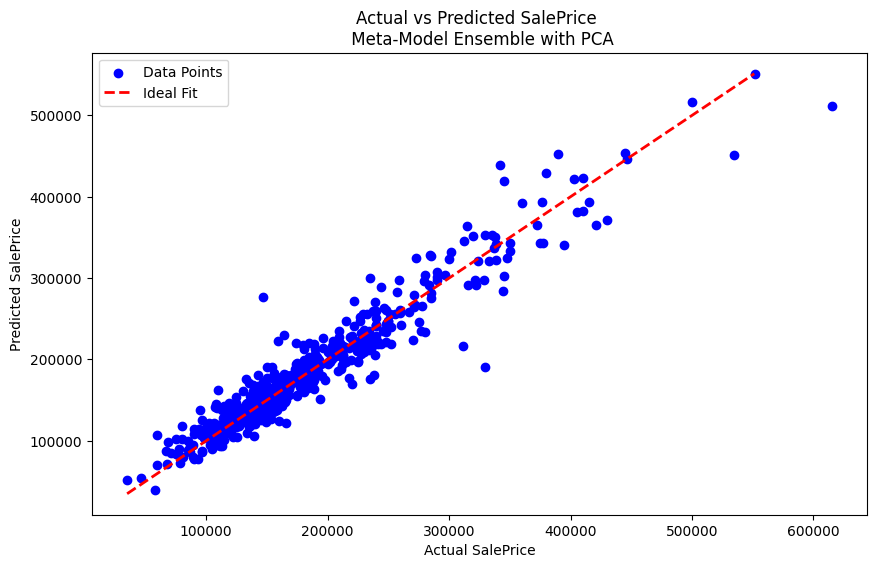

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import time

# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
start_time_pca = time.time()
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)
end_time_pca = time.time()
print(f"PCA Training Time: {end_time_pca - start_time_pca:.2f} seconds")

# Train Gradient Boosting
start_time_gb = time.time()
gb_model = GradientBoostingRegressor(subsample=0.8, n_estimators=300, max_depth=3, learning_rate=0.1)
gb_model.fit(X_train_pca, y_train)
end_time_gb = time.time()
gb_train_pred = gb_model.predict(X_train_pca)
gb_test_pred = gb_model.predict(X_test_pca)
print(f"Gradient Boosting Training Time: {end_time_gb - start_time_gb:.2f} seconds")

# Train XGBoost
start_time_xgb = time.time()
xgb_model = XGBRegressor(subsample=0.6, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6)
xgb_model.fit(X_train_pca, y_train)
end_time_xgb = time.time()
xgb_train_pred = xgb_model.predict(X_train_pca)
xgb_test_pred = xgb_model.predict(X_test_pca)
print(f"XGBoost Training Time: {end_time_xgb - start_time_xgb:.2f} seconds")

# Train SVR
start_time_svr = time.time()
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_pca, y_train)
end_time_svr = time.time()
svr_train_pred = svr_model.predict(X_train_pca)
svr_test_pred = svr_model.predict(X_test_pca)
print(f"SVR Training Time: {end_time_svr - start_time_svr:.2f} seconds")

# Stack the predictions as new features
train_stack = np.column_stack((gb_train_pred, xgb_train_pred, svr_train_pred))
test_stack = np.column_stack((gb_test_pred, xgb_test_pred, svr_test_pred))

# Train a meta-model (Linear Regression) on these stacked features
start_time_meta = time.time()
meta_model = LinearRegression()
meta_model.fit(train_stack, y_train)
end_time_meta = time.time()

# Make predictions using the meta-model
start_time_meta_pred = time.time()
meta_train_pred = meta_model.predict(train_stack)
meta_test_pred = meta_model.predict(test_stack)
end_time_meta_pred = time.time()

# Un-transform the predictions back to the original scale
meta_test_pred_original = saleprice_scaler.inverse_transform(meta_test_pred.reshape(-1, 1)).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the meta-model
mae_meta = mean_absolute_error(y_test_original, meta_test_pred_original)
mse_meta = mean_squared_error(y_test_original, meta_test_pred_original)

print("Meta-Model Ensemble Performance with PCA:")
print(f"Mean Absolute Error (MAE): ${mae_meta:.2f}")
print(f"Mean Squared Error (MSE): ${mse_meta:.2f}")
print(f"PCA Training Time: {end_time_pca - start_time_pca:.2f} seconds")
print(f"Gradient Boosting Training Time: {end_time_gb - start_time_gb:.2f} seconds")
print(f"XGBoost Training Time: {end_time_xgb - start_time_xgb:.2f} seconds")
print(f"SVR Training Time: {end_time_svr - start_time_svr:.2f} seconds")
print(f"Meta-Model Training Time: {end_time_meta - start_time_meta:.2f} seconds")
print(f"Meta-Model Prediction Time: {end_time_meta_pred - start_time_meta_pred:.2f} seconds")

# Plot actual vs predicted for the meta-model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, meta_test_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), meta_test_pred_original.max()], [y_test_original.min(), meta_test_pred_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Meta-Model Ensemble with PCA')
plt.legend()
plt.show()


Train individual models and get predictions with PCA and RFE and then ensemble models using blending


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 3.13 seconds
PCA Training Time: 3.13 seconds
Training Time for RFE: 201.78 seconds
RFE Training Time: 201.78 seconds
Gradient Boosting Training Time: 6.17 seconds
XGBoost Training Time: 0.27 seconds
SVR Train

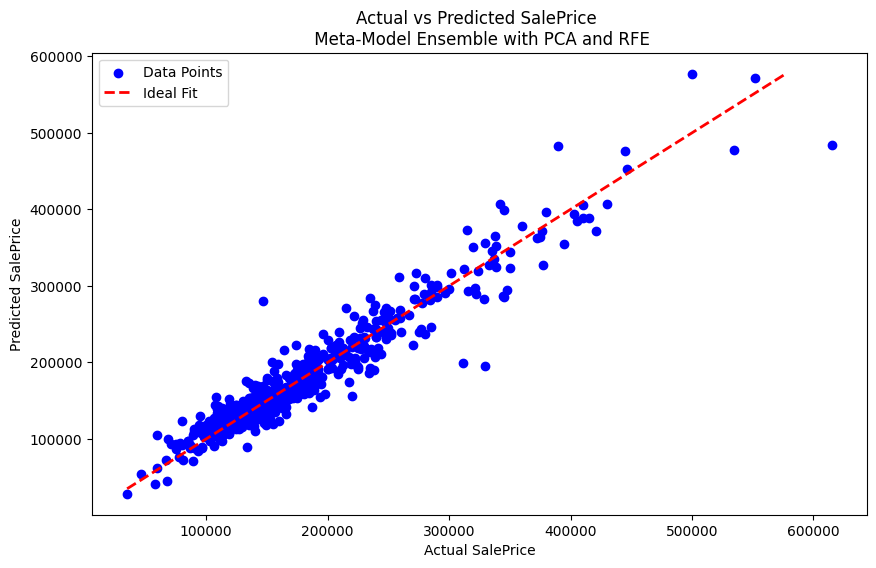

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import time

# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
start_time_pca = time.time()
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)
end_time_pca = time.time()
print(f"PCA Training Time: {end_time_pca - start_time_pca:.2f} seconds")

# Apply RFE
start_time_rfe = time.time()
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=30)
X_test_rfe = rfe.transform(X_test_pca)
end_time_rfe = time.time()
print(f"RFE Training Time: {end_time_rfe - start_time_rfe:.2f} seconds")

# Train Gradient Boosting
start_time_gb = time.time()
gb_model = GradientBoostingRegressor(subsample=0.8, n_estimators=300, max_depth=3, learning_rate=0.1)
gb_model.fit(X_train_rfe, y_train)
end_time_gb = time.time()
gb_train_pred = gb_model.predict(X_train_rfe)
gb_test_pred = gb_model.predict(X_test_rfe)
print(f"Gradient Boosting Training Time: {end_time_gb - start_time_gb:.2f} seconds")

# Train XGBoost
start_time_xgb = time.time()
xgb_model = XGBRegressor(subsample=0.6, n_estimators=500, max_depth=3, learning_rate=0.05, colsample_bytree=0.6)
xgb_model.fit(X_train_rfe, y_train)
end_time_xgb = time.time()
xgb_train_pred = xgb_model.predict(X_train_rfe)
xgb_test_pred = xgb_model.predict(X_test_rfe)
print(f"XGBoost Training Time: {end_time_xgb - start_time_xgb:.2f} seconds")

# Train SVR
start_time_svr = time.time()
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_rfe, y_train)
end_time_svr = time.time()
svr_train_pred = svr_model.predict(X_train_rfe)
svr_test_pred = svr_model.predict(X_test_rfe)
print(f"SVR Training Time: {end_time_svr - start_time_svr:.2f} seconds")

# Stack the predictions as new features
train_stack = np.column_stack((gb_train_pred, xgb_train_pred, svr_train_pred))
test_stack = np.column_stack((gb_test_pred, xgb_test_pred, svr_test_pred))

# Train a meta-model (Linear Regression) on these stacked features
start_time_meta = time.time()
meta_model = LinearRegression()
meta_model.fit(train_stack, y_train)
end_time_meta = time.time()

# Make predictions using the meta-model
start_time_meta_pred = time.time()
meta_train_pred = meta_model.predict(train_stack)
meta_test_pred = meta_model.predict(test_stack)
end_time_meta_pred = time.time()

# Un-transform the predictions back to the original scale
meta_test_pred_original = saleprice_scaler.inverse_transform(meta_test_pred.reshape(-1, 1)).flatten()
y_test_original = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Evaluate the meta-model
mae_meta = mean_absolute_error(y_test_original, meta_test_pred_original)
mse_meta = mean_squared_error(y_test_original, meta_test_pred_original)

print("Meta-Model Ensemble Performance with PCA and RFE:")
print(f"Mean Absolute Error (MAE): ${mae_meta:.2f}")
print(f"Mean Squared Error (MSE): ${mse_meta:.2f}")
print(f"PCA Training Time: {end_time_pca - start_time_pca:.2f} seconds")
print(f"RFE Training Time: {end_time_rfe - start_time_rfe:.2f} seconds")
print(f"Gradient Boosting Training Time: {end_time_gb - start_time_gb:.2f} seconds")
print(f"XGBoost Training Time: {end_time_xgb - start_time_xgb:.2f} seconds")
print(f"SVR Training Time: {end_time_svr - start_time_svr:.2f} seconds")
print(f"Meta-Model Training Time: {end_time_meta - start_time_meta:.2f} seconds")
print(f"Meta-Model Prediction Time: {end_time_meta_pred - start_time_meta_pred:.2f} seconds")

# Plot actual vs predicted for the meta-model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, meta_test_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), meta_test_pred_original.max()], [y_test_original.min(), meta_test_pred_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Meta-Model Ensemble with PCA and RFE')
plt.legend()
plt.show()
